In [1]:
import json
import os
import time
import ipyparallel as ipp

import matplotlib.pyplot as plt
import torch
import dfca as DFCA
import ifca as IFCA

import numpy as np

from util import *

Reads Config file and prepares the arguments you can choose in the config_dfca.json/config_ifca.json

In [2]:
rc = ipp.Cluster(n=3).start_and_connect_sync()
rc.activate()

rc.ids 

dview = rc[:]

Starting 3 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/3 [00:00<?, ?engine/s]

In [3]:
learning_rates = [0.25]

dfca_li = []
dfca_gi = []
ifca = []

In [4]:
%%px --targets all

import sys
import os
import random
sys.path.append(os.getcwd())

random.seed(42)
seeds = random.sample(range(10000), 5)
learning_rates = [0.25]

dfca_li = []
dfca_gi = []
ifca = []

Running the dfca-gi experiment

In [5]:
%%px --target 0 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_gi.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_gi.append(res_mean)



<AsyncResult(%px): pending>

Running the dfca-li experiment


In [6]:
%%px --target 1 --noblock
import dfca as DFCA
import json
import time
import torch
import numpy as np


with open("config_dfca_li.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------DFCA-LI, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = DFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    dfca_li.append(res_mean)



<AsyncResult(%px): pending>

Running the ifca experiment

In [7]:
%%px --target 2 --noblock
import ifca as IFCA
import json
import time
import torch
import numpy as np

with open("config_ifca.json", "r") as read_file:
    config = json.load(read_file)

for lr in learning_rates:
    config['lr'] = lr
    res_final = []

    for seed in seeds:
        print(f"---------------------------------IFCA, lr: {lr}, seed: {seed}---------------------------------")
        start_time = time.time()
        config['data_seed'] = seed
        config['train_seed'] = config['data_seed']

        print("config:",config)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        exp = IFCA.TrainEMNISTCluster(config, device)
        exp.setup()
        res = exp.run()
        res_final.append([[r['test']['loss'] for r in res], [r['test']['acc'] for r in res], [r['test']['cl_acc'] for r in res]])
        del exp
        duration = (time.time() - start_time)
        print("---train cluster Ended in %0.2f hour (%.3f sec) " % (duration/float(3600), duration))

    res_mean = np.mean(res_final, axis=0).tolist()
    ifca.append(res_mean)



<AsyncResult(%px): pending>

Experiment Final Results: 

In [8]:
rc.wait_interactive()
_.display_outputs()

dfca_gi = rc[0].pull('dfca_gi', block=True)
dfca_li = rc[1].pull('dfca_li', block=True)
ifca = rc[2].pull('ifca', block=True)

unknown:   0%|          | 0/3 [00:00<?, ?tasks/s]

---------------------------------IFCA, lr: 0.25, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': False, 'h1': 200, 'num_epochs': 300, 'batch_size': 100, 'tau': 5, 'lr': 0.25, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_ifca'}
Using device: cuda
Epoch -1 tr: l 3.871 a 0.020 clct[np.int64(123), np.int64(77)] cl_acc 0.575  1.883sec
Epoch -1 tst: l 3.870 a 0.021 clct[np.int64(22), np.int64(18)] cl_acc 0.600  0.339sec
Epoch 0 tr: l 2.879 a 0.270 clct[np.int64(100), np.int64(100)] cl_acc 1.000  lr 0.250000 12.029sec(train) 2.426sec(infer)
Epoch 0 tst: l 2.892 a 0.263 clct[np.int64(20), np.int64(20)] cl_acc 1.000  0.579sec
result written at output_ifca/results.pickle
checkpoint written at output_ifca/checkpoint.pt
Epoch 1 tr: l 1.573 a 0.618 clct[np.int64(100), np.int64(100)] cl_acc 1.000  lr 0.248750 9.634sec(train) 1.860sec(infer)
Epoch 1 tst: l 1.588 a 0.613 clct[np.int64(20), np.int64(20)] cl

In [9]:
__.display_outputs()

---------------------------------DFCA-LI, lr: 0.25, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': False, 'local_model_init': True, 'h1': 200, 'num_epochs': 300, 'batch_size': 100, 'tau': 5, 'lr': 0.25, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_dfca_li'}
Using device: cuda
<class 'list'>
<class 'list'>
Epoch -1 tr: l 3.869 a 0.023 clct[np.int64(96), np.int64(104)] cl_acc 0.530  4.484sec
Epoch -1 tst: l 3.869 a 0.026 clct[np.int64(17), np.int64(23)] cl_acc 0.625  2.189sec
Epoch 0 tr: l 3.427 a 0.254 clct[np.int64(104), np.int64(96)] cl_acc 0.530  lr 0.250000 10.165sec(train) 4.322sec(infer)
Epoch 0 tst: l 3.671 a 0.141 clct[np.int64(17), np.int64(23)] cl_acc 0.575  2.193sec
result written at output_dfca_li/results.pickle
checkpoint written at output_dfca_li/checkpoint.pt
Epoch 1 tr: l 3.366 a 0.256 clct[np.int64(105), np.int64(95)] cl_acc 0.505  lr 0.248750 10.611sec(train) 4.574sec(infe

In [10]:
___.display_outputs()

---------------------------------DFCA-LI, lr: 0.25, seed: 1824---------------------------------
config: {'m': 200, 'm_test': 40, 'p': 2, 'n': 500, 'uneven': False, 'local_model_init': False, 'h1': 200, 'num_epochs': 300, 'batch_size': 100, 'tau': 5, 'lr': 0.25, 'data_seed': 1824, 'train_seed': 1824, 'config_override': '', 'project_dir': 'output_dfca_gi'}
Using device: cuda
<class 'list'>
<class 'list'>
Epoch -1 tr: l 3.867 a 0.024 clct[np.int64(172), np.int64(28)] cl_acc 0.630  1.892sec
Epoch -1 tst: l 3.868 a 0.028 clct[np.int64(35), np.int64(5)] cl_acc 0.625  0.567sec
Epoch 0 tr: l 2.578 a 0.372 clct[np.int64(157), np.int64(43)] cl_acc 0.685  lr 0.250000 9.042sec(train) 2.197sec(infer)
Epoch 0 tst: l 2.795 a 0.296 clct[np.int64(29), np.int64(11)] cl_acc 0.775  0.927sec
result written at output_dfca_gi/results.pickle
checkpoint written at output_dfca_gi/checkpoint.pt
Epoch 1 tr: l 1.800 a 0.551 clct[np.int64(133), np.int64(67)] cl_acc 0.815  lr 0.248750 9.616sec(train) 2.695sec(infer)

{'test_loss': [[3.8694302189350127, 2.8311266708374023, 1.6751177048683168, 1.17351557046175, 0.9761808225512505, 0.8678280177712441, 0.7880303880572319, 0.7329665663838386, 0.6949890965223313, 0.6593735724687575, 0.6374401408433914, 0.6131525127589702, 0.5973879988491535, 0.5787887199223042, 0.5702993737161159, 0.5556726056337358, 0.5487392120063305, 0.5382424657046795, 0.5329965068399906, 0.5252736182510853, 0.5201890851557255, 0.5137697416543962, 0.5103251418471336, 0.504299669712782, 0.5013085396587849, 0.4956558261811733, 0.4928599572181701, 0.4883218637108803, 0.4861373946070671, 0.4819989316165447, 0.48025467038154607, 0.47656990319490433, 0.47551137626171114, 0.47213180884718886, 0.4714753799140453, 0.4682306864857674, 0.46780604869127274, 0.46476103469729424, 0.46486468419432636, 0.46205645278096197, 0.4621505032479763, 0.4596069346368313, 0.4597449682652951, 0.4573318612575531, 0.4575812056660652, 0.4552674797177315, 0.4556136193871498, 0.4534134483337402, 0.45381992384791375

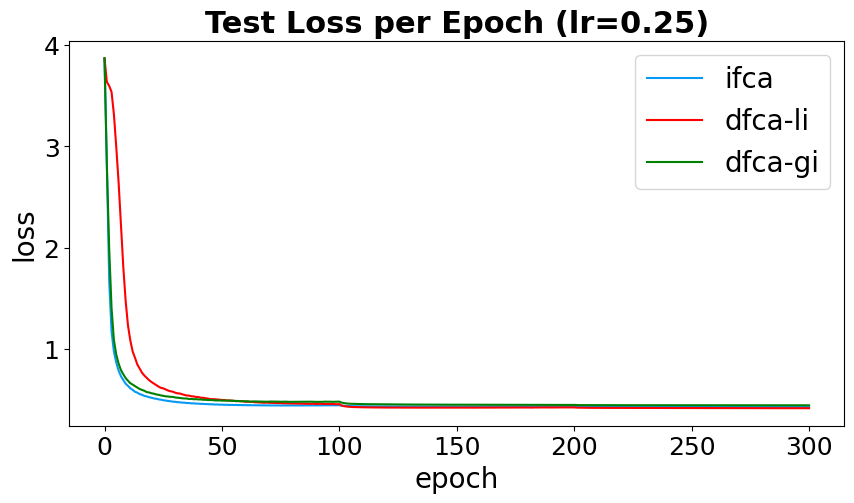

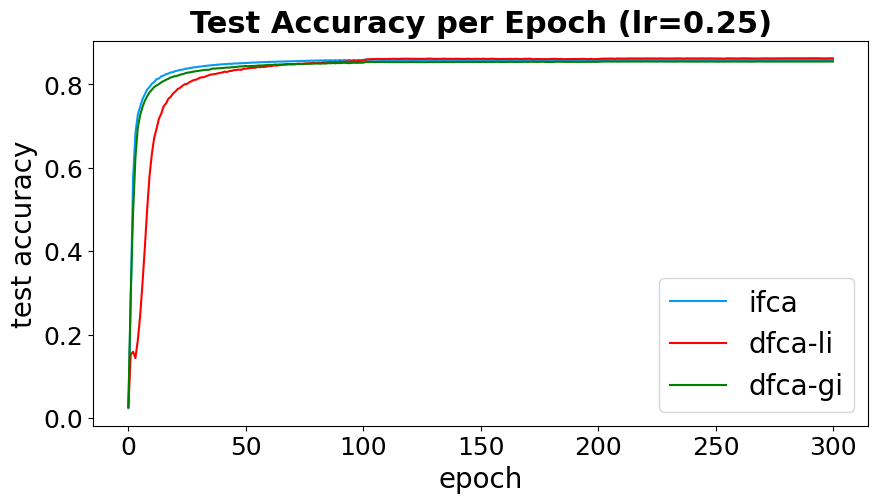

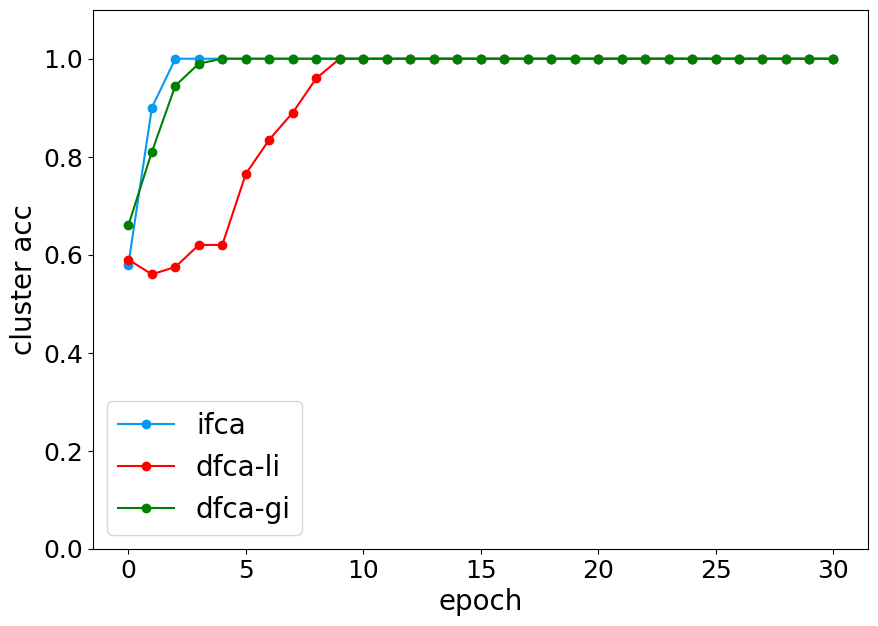

In [11]:

r_ifca = {}
r_dfca_gi = {}
r_dfca_li = {}

r_ifca['test_loss'] = []
r_ifca['test_acc'] = []
r_ifca['cl_acc'] = []
for i in range(len(learning_rates)):
    r_ifca['test_loss'].append(ifca[i][0])
    r_ifca['test_acc'].append(ifca[i][1])
    r_ifca['cl_acc'].append(ifca[i][2])

r_dfca_gi['test_loss'] = []
r_dfca_gi['test_acc'] = []
r_dfca_gi['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_gi['test_loss'].append(dfca_gi[i][0])
    r_dfca_gi['test_acc'].append(dfca_gi[i][1])
    r_dfca_gi['cl_acc'].append(dfca_gi[i][2])

r_dfca_li['test_loss'] = []
r_dfca_li['test_acc'] = []
r_dfca_li['cl_acc'] = []
for i in range(len(learning_rates)):
    r_dfca_li['test_loss'].append(dfca_li[i][0])
    r_dfca_li['test_acc'].append(dfca_li[i][1])
    r_dfca_li['cl_acc'].append(dfca_li[i][2])

print(r_ifca)

os.makedirs('graphs', exist_ok=True)

for l in range(len(learning_rates)):

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_loss'][l], label='ifca', color='xkcd:azure')
    plt.plot(r_dfca_li['test_loss'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_loss'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.title(f'Test Loss per Epoch (lr={learning_rates[l]})', fontsize=22, fontweight='bold')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(fontsize=20)
    plt.savefig(os.path.join('graphs', 'train_loss.png'))

    plt.figure(figsize=(10,5))
    plt.plot(r_ifca['test_acc'][l], label='ifca', color='xkcd:azure')
    plt.plot(r_dfca_li['test_acc'][l], label='dfca-li', color='red')
    plt.plot(r_dfca_gi['test_acc'][l], label='dfca-gi', color='green')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('test accuracy', fontsize=20)
    plt.title(f'Test Accuracy per Epoch (lr={learning_rates[l]})', fontsize=22, fontweight='bold')
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.legend(fontsize=20)
    plt.savefig(os.path.join('graphs', 'test_acc.png'))

    plt.figure(figsize=(10,7))
    plt.ylim([0, 1.1])
    plt.plot(r_ifca['cl_acc'][l][:31], label='ifca', color='xkcd:azure', marker='o')
    plt.plot(r_dfca_li['cl_acc'][l][:31], label='dfca-li', color='red', marker='o')
    plt.plot(r_dfca_gi['cl_acc'][l][:31], label='dfca-gi', color='green', marker='o')
    plt.xlabel('epoch', fontsize=20)
    plt.ylabel('cluster acc', fontsize=20)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.savefig(os.path.join('graphs', 'cluster_acc.png'))